In [7]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import math
import numpy as np

Retrieving and cleaning data on the first dataset.

In [4]:
#First Dataframe ##########################
url_1 = "http://www.jmulti.de/download/datasets/e2.dat"
df_1  = pd.read_csv(url_1).iloc[:,:1]
df_1 = df_1.iloc[:,0].str.split()[7:]
df_fix = pd.DataFrame(columns = ["US Fixed Investment (1947-1974)", "Quaterly Changes"])
df_fix["US Fixed Investment (1947-1974)"] = [float(element[0]) for element in df_1]
df_fix["Quaterly Changes"] = [float(element[1]) for element in df_1]
#Second Dataframe ##########################
url_2 = "http://www.jmulti.de/download/datasets/e3.dat"
df_2  = pd.read_csv(url_1).iloc[:,:1]
df_2 = df_2.iloc[:,0].str.split()[8:]
df_yield = pd.DataFrame()
df_yield["Quaterly German Nominal GDP"] = [float(element[0]) for element in df_2]
#Third Dataframe ##########################
url_3 = "http://www.jmulti.de/download/datasets/NP_xetradax_returns100.dat"
df_3  = pd.read_csv(url_3, on_bad_lines='skip').iloc[:,:1]
df_3 = df_3.iloc[:,0].str.split()[7:]
df_stock = pd.DataFrame()
df_stock["DAX Daily Returns"] = [float(element[0]) for element in df_3]
#Fourth Dataframe: Disposable income ##########################
url_4 = "http://www.jmulti.de/download/datasets/e4.dat"
df_4  = pd.read_csv(url_4, on_bad_lines='skip').iloc[:,:1]
df_4 = df_4.iloc[:,0].str.split()[7:]
df_disposable = pd.DataFrame()
df_disposable["Quaterly Per Capital Disposible Income"] = [float(element[0]) for element in df_4]

### Observations

This dataset appears to fluctuate randomly <b>around a constant mean</b> with an <b>homogeneous variability</b>. 

Correlation between consecutive variables seem possible.

<i>Aqui observamos una serie temporal que fluctua alrededor de una media fija, esta fluctuacion es de caracter aleatorio, pero la varianza alrededor de esta media en cuestion no parece ser muy aleatoria, sino homogenea </i>

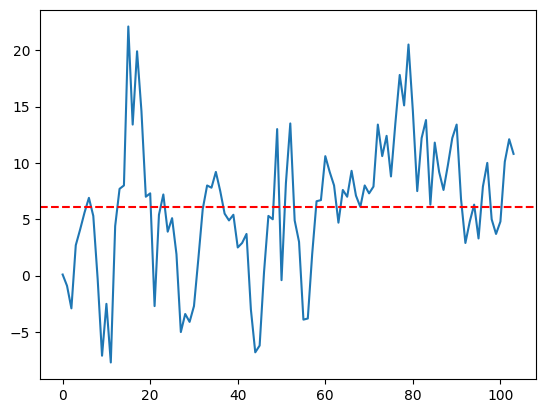

In [102]:
df_fix["Quaterly Changes"].plot()
plt.axhline(y = df_fix["Quaterly Changes"].mean(), color = "r", linestyle = "dashed")

### Observations

This dataset appears to evolve <b>around a deterministic polynomial trend</b> with a <b>seasonal movement</b>. <br>

<i>Aqui estamos viendo una tendencia al alza determinista (es decir la tendencia de esta serie temporal es de caracter no aleatorio, es una tendencia solida que no depende del azar). </i>

<AxesSubplot:>

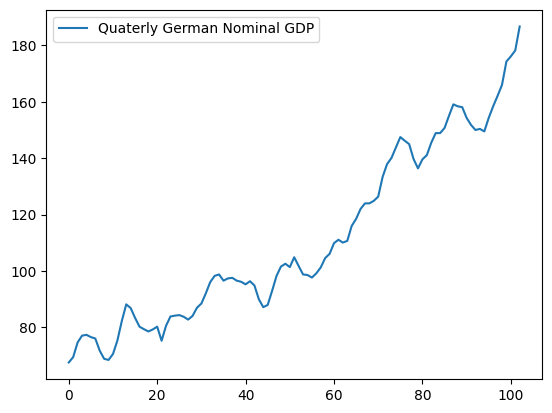

In [103]:
df_yield.plot()

### Observations

This dataset <b>moves around a fixed mean value</b> with <b>dissimilar variability</b>. <br>

<i>Vemos una serie que evoluciona de forma constante alrededor de una media fija. Sin embargo la variabilidad con la que se mueve alrededor de esta media no parece nada constante. </i>

<AxesSubplot:>

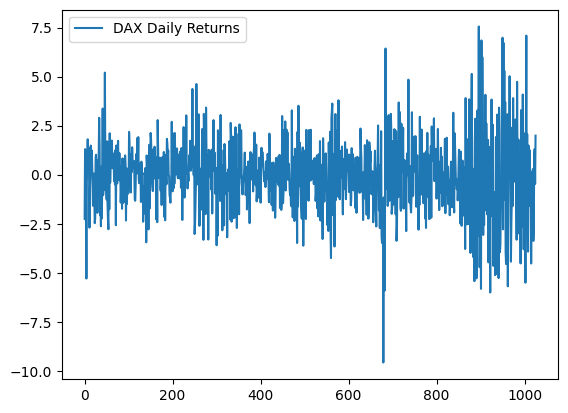

In [105]:
df_stock.plot()

### Stationarity

We will say that a stochastic process (set of random variables) is <b>stationary</b> if it has time-invariant first and second moments. In other words:<br>

 -  $\mathbb{E}[y_t] = \mu_y \text{ for all }t \in T$
 - $\mathbb{E}[(y_t - \mu_y)(y_{t-h} - \mu_y)] = \gamma_h \text{ for all }t \in T \text{ and all  integers } h \text{  such that } t-h \in T $

<i>Lo importante es que la covarianza que tenga la serie con respecto a si mismo con lag, no depende de $t$ sino unica y exclusivamente del tiempo que ha pasado entre las dos observaciones: $h$. Si escojemos $h = 0$ la varianza de la serie temporal es constante. </i><br>

The first time-serie we analyzed seems to be stationnary. The DAX serie doesn't seem stationary because variability not constant. 

### Autocorrelations

 - Sample Autocorrelation:  $\tilde{\rho_h} = \frac{\tilde{\gamma_h}}{\tilde{\gamma_0}}$
 - Sample Covariance: $\tilde{\gamma_h} = \frac{1}{T} \sum (y_t - \bar{y})(y_{t-h} - \bar{y})$
 - If all the autocorrelations are 0 for a time-series, the time-series is called <b>white noise</b>

For a stationary time series the autocorrelation die quickly as we increase $h$.

### Spectral Densities

The autocorrelations of a stationaty stochastic ptocess may be summarized in the <b>spectal density</b> function: 

$$f_y(\lambda) = (2\pi)^{-1}\sum_{j = - \infty}^{\infty} \gamma_j e^{-i	\lambda j} = (2\pi)^{-1} \left( \gamma_0 + 2\sum_{j = 1}^{\infty} \gamma_j cos({\lambda j}) \right)$$

- <i>En la ultima igualdad utilizamos que el coseno es una funcion par y el seno impar (se anulan los senos). Tambien utilizamos la simetria de la auto-covarianza como funcion de $j$, $\gamma_j = \gamma_{-j}$</i>

<b>Recover the autocovariance coefficient from the spectral density funtion</b>
$$\gamma_j = \int_{-\pi}^{\pi} e^{i\lambda j} f_y(h)d\lambda$$

### Estimating Spectral Density

A good estimator for this spectral density function is: 
$$\tilde{f_y}(\lambda) = (2\pi)^{-1} \left( \omega_0\tilde{\gamma_0} + 2\sum_{j = 1}^{M_T} \omega_j\tilde{\gamma_j} cos({\lambda j}) \right)$$
- The omegas are some weights we will give to every autocovariance coefficient, the more the lag increase the lower the omega will be. 
- $M_T$ is the truncation point. We will only sum up to a given point that may change dependind on sample size.

#### Barrett Spectral Window Proposition

The higher the lag, the fewer observations we have to compute autocovariance, the less weight. 

$$\omega_j =1 -\frac{j}{M_T}$$

### Interpretation of Spectre

- Low frequency dominance: Trend
- Basically what a spectral plotting analysis tells you is, looking at the peaks which frequencies dominates in terms of radians

In [11]:
def spectral_density(time_series, lambda_, truncation_period):
    weights = [1 - j/truncation_period for j in range(truncation_period)]
    autocorrelations = []
    for j in range(truncation_period):
        autocorrelations.append(time_series.autocorr(lag=j))
    output = 1/(2*math.pi)*(weights[0]*autocorrelations[0] + 2*sum([weights[j]*autocorrelations[j]*math.cos(lambda_*j) for j in range(1, truncation_period)]))
    return output
        

<AxesSubplot:>

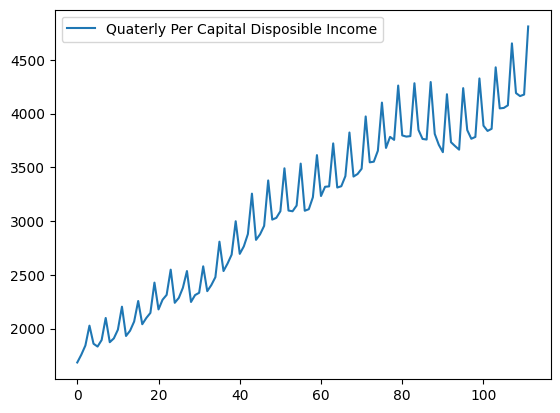

In [12]:
df_disposable.plot()

In [18]:
spectre = [spectral_density(df_disposable.squeeze(), element, 20) for element in np.linspace(0, math.pi, num = 150)]

[]

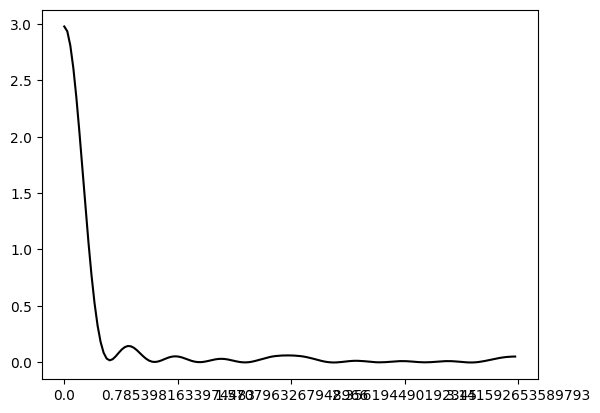

In [28]:
plt.plot(spectre, color='black')
xi = np.linspace(0, 150, num = 5)
[]
plt.xticks(np.linspace(0, 150, num = 5), np.linspace(0, math.pi, num = 5))
plt.plot()